In [2]:
import json
import multiprocessing as mp
import os
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore
from scipy.interpolate import interp1d

In [64]:
# Save to a JSON file
evolve_mass_loss = 0.45

it_min = 0
it_max = 100
# it_max = 100

sim = "m12i"

sim_dir = "/Users/z5114326/Documents/simulations/"
save_dir = "../data/gc_mass_data/"

mass_file = save_dir + sim + "_mass_data.hdf5"  # save location
mass_data = proc_data = h5py.File(mass_file, "r")  # open processed data file

# Lets plot

First lets get common time grids across all iterations

In [77]:
def time_bounds(mass_data):
    # the min for both these time frames will be 0
    time_max = 0
    form_time_max = 0

    acc_time_min = 0
    acc_time_max = 0

    for it_id in mass_data.keys():
        it_mass = mass_data[it_id]

        for gc_id in it_mass.keys():
            it_time_max = np.max(it_mass[gc_id]["time"])
            time_max = np.max([time_max, it_time_max])

            it_form_time_max = np.max(it_mass[gc_id]["form_time"])
            form_time_max = np.max([form_time_max, it_form_time_max])

            if it_mass[gc_id]["type_flag"][()] > 1:
                it_acc_time_min = np.min(it_mass[gc_id]["acc_time"])
                it_acc_time_max = np.max(it_mass[gc_id]["acc_time"])

                acc_time_min = np.min([acc_time_min, it_acc_time_min])
                acc_time_max = np.max([acc_time_max, it_acc_time_max])

    time_bounds_dict = {
        "time": [0, time_max],
        "form_time": [0, form_time_max],
        "acc_time": [acc_time_min, acc_time_max],
    }

    return time_bounds_dict

In [ ]:
time_bounds_dict = time_bounds(mass_data)
print(time_bounds_dict)

In [79]:
time_bounds_dict

{'time': [0, 13.83],
 'form_time': [0, 13.061112094],
 'acc_time': [-12.488776855000001, 11.471]}

In [80]:
time_step = 1000
time_grid = np.linspace(time_bounds_dict["time"][0], time_bounds_dict["time"][1], time_step)
form_time_grid = np.linspace(time_bounds_dict["form_time"][0], time_bounds_dict["form_time"][1], time_step)
acc_time_grid = np.linspace(time_bounds_dict["acc_time"][0], time_bounds_dict["acc_time"][1], time_step)

In [96]:
np.isnan(mass_data["it000"]["100008371"]["log_mass"][-1])

True

In [81]:
def safe_interpolate(x, y, common_grid):
    interp_func = interp1d(x, y, kind="nearest", bounds_error=False, fill_value=(0, 1))
    return interp_func(common_grid)

In [97]:
log_mass_lst = mass_data["it000"]["100008371"]["log_mass"]
log_mass_lst

<HDF5 dataset "log_mass": shape (9,), type "<f8">

In [103]:
log_mass_lst[()]

array([4.015, 3.74 ,   nan])

In [104]:
for log_mass in log_mass_lst:
    if not np.isnan(log_mass):
        print(log_mass)

4.015
3.74


In [105]:
it_min = 0
it_max = 0

####################################
plot_dict = {}

plot_dict["time"] = time_grid
plot_dict["form_time"] = form_time_grid
plot_dict["acc_time"] = acc_time_grid

####################################

# for it_id in mass_data.keys():
for it in range(0, 1):
    it_id = iteration_name(it)

    # data_file = save_dir + "/" + it_id + "_gc_mass_data.json"
    # # open json file as dict
    # with open(data_file, "r") as file:
    #     it_mass = json.load(file)

    plot_dict[it_id] = {}

    plot_dict[it_id]["0"] = {}
    plot_dict[it_id]["1"] = {}
    plot_dict[it_id]["2"] = {}
    plot_dict[it_id]["3"] = {}
    plot_dict[it_id]["4"] = {}

    # set up dictionary
    for type_flag_val in range(0, 5):
        plot_dict[it_id][str(type_flag_val)] = {}

        #######################################################################################
        # need to make a mass list for each time frame
        # cosmic time
        time_len = len(plot_dict["time"])
        plot_dict[it_id][str(type_flag_val)]["time"] = {}
        plot_dict[it_id][str(type_flag_val)]["time"]["mass"] = np.zeros(time_len)
        plot_dict[it_id][str(type_flag_val)]["time"]["mass_loss"] = np.zeros(time_len)
        plot_dict[it_id][str(type_flag_val)]["time"]["mass_loss_det"] = np.zeros(time_len)

        # formation time
        time_len = len(plot_dict["form_time"])
        plot_dict[it_id][str(type_flag_val)]["form_time"] = {}
        plot_dict[it_id][str(type_flag_val)]["form_time"]["mass"] = np.zeros(time_len)
        plot_dict[it_id][str(type_flag_val)]["form_time"]["mass_loss"] = np.zeros(time_len)
        plot_dict[it_id][str(type_flag_val)]["form_time"]["mass_loss_det"] = np.zeros(time_len)

        # accretion time
        if type_flag_val > 1:
            time_len = len(plot_dict["acc_time"])
            plot_dict[it_id][str(type_flag_val)]["acc_time"] = {}
            plot_dict[it_id][str(type_flag_val)]["acc_time"]["mass"] = np.zeros(time_len)
            plot_dict[it_id][str(type_flag_val)]["acc_time"]["mass_loss"] = np.zeros(time_len)
            plot_dict[it_id][str(type_flag_val)]["acc_time"]["mass_loss_det"] = np.zeros(time_len)

        #######################################################################################
    for gc_id in mass_data[it_id]:
        type_flag = mass_data[it_id][gc_id]["type_flag"][()]

        time_lst = mass_data[it_id][gc_id]["time"]
        form_time_lst = mass_data[it_id][gc_id]["form_time"]

        log_mass_lst = mass_data[it_id][gc_id]["log_mass"]

        mass_loss_lst = mass_data[it_id][gc_id]["mass_loss"]
        mass_loss_det_lst = mass_data[it_id][gc_id]["mass_loss_detectable"]

        mass_lst = []
        for log_mass in log_mass_lst:
            if not np.isnan(log_mass):
                mass = 10**log_mass
            else:
                mass = 0
            mass_lst.append(mass)

        ########################################################################################3
        # cosmic time
        time_mass = safe_interpolate(time_lst, mass_lst, plot_dict["time"])
        time_mass_loss = safe_interpolate(time_lst, mass_loss_lst, plot_dict["time"])
        time_mass_loss_det = safe_interpolate(time_lst, mass_loss_det_lst, plot_dict["time"])

        plot_dict[it_id][str(type_flag)]["time"]["mass"] += time_mass
        plot_dict[it_id][str(type_flag)]["time"]["mass_loss"] += time_mass_loss
        plot_dict[it_id][str(type_flag)]["time"]["mass_loss_det"] += time_mass_loss_det

        # formation time
        form_time_mass = safe_interpolate(form_time_lst, mass_lst, plot_dict["form_time"])
        form_time_mass_loss = safe_interpolate(form_time_lst, mass_loss_lst, plot_dict["form_time"])
        form_time_mass_loss_det = safe_interpolate(form_time_lst, mass_loss_det_lst, plot_dict["form_time"])

        plot_dict[it_id][str(type_flag)]["form_time"]["mass"] += form_time_mass
        plot_dict[it_id][str(type_flag)]["form_time"]["mass_loss"] += form_time_mass_loss
        plot_dict[it_id][str(type_flag)]["form_time"]["mass_loss_det"] += form_time_mass_loss_det

        # accretion time
        if type_flag > 1:
            acc_time_lst = mass_data[it_id][gc_id]["acc_time"]

            acc_time_mass = safe_interpolate(acc_time_lst, mass_lst, plot_dict["acc_time"])
            acc_time_mass_loss = safe_interpolate(acc_time_lst, mass_loss_lst, plot_dict["acc_time"])
            acc_time_mass_loss_det = safe_interpolate(acc_time_lst, mass_loss_det_lst, plot_dict["acc_time"])

            plot_dict[it_id][str(type_flag)]["acc_time"]["mass"] += acc_time_mass
            plot_dict[it_id][str(type_flag)]["acc_time"]["mass_loss"] += acc_time_mass_loss
            plot_dict[it_id][str(type_flag)]["acc_time"]["mass_loss_det"] += acc_time_mass_loss_det

In [107]:
plot_dict.keys()

dict_keys(['time', 'form_time', 'acc_time', 'it000'])

In [108]:
for key in plot_dict.keys():
    if "time" in key:
        print(key)

time
form_time
acc_time


In [117]:
# plot_dict["it000"]["0"]["time"]["mass"]

plot_dict["it000"]["0"]["time"]["mass"]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

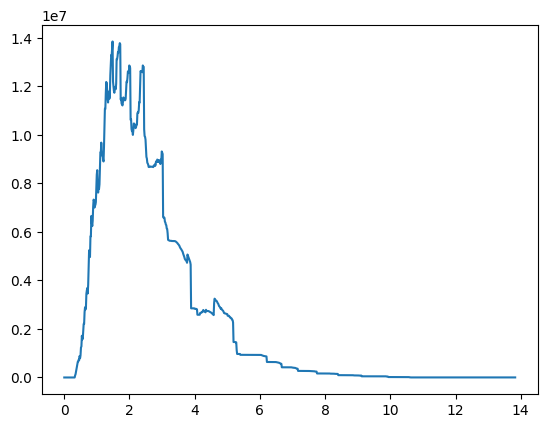

In [106]:
plt.plot(plot_dict["time"], plot_dict[it_id][str(4)]["time"]["mass"])

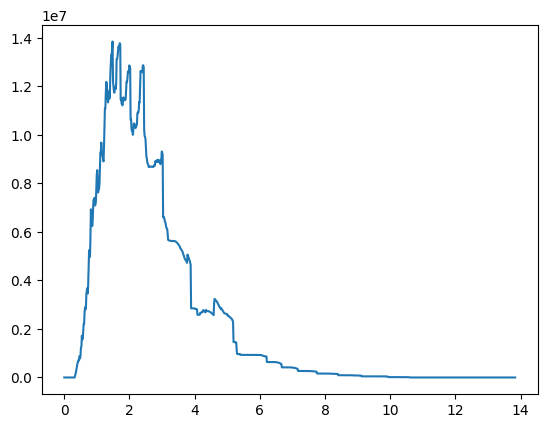

In [3]:
path = "/Users/z5114326/Documents/GitHub/gc_statistics/data/mass_data/m12i_gc_type_mass_data.hdf5"
data = proc_data = h5py.File(path, "r")  # open processed data file

time = data["time"][()]
mass = data["it000"]["4"]["time"]["mass"][()]

plt.plot(time, mass)

In [5]:
data.close()


In [146]:
print()
print("hi")


hi
